# Flood Aread Segmentation
---

### Import libraries 

In [1]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from keras import backend as K
import segmentation_models as sm
import albumentations as A
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


---
### Load the data

In [2]:
PATH = "/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/"
df = pd.read_csv(PATH + "metadata.csv")
df.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


---
### Transform the data 

In [3]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 3, p = 0.5),
    # A.RandomRotate90(p=1) ,
    # A.Rotate(limit=90,p=0.5) ,
    # A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
    
])

In [4]:
# Let's load the Image and the Mask data
df['Image'] = df['Image'].map(lambda x: PATH + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'Mask/' + x)


In [5]:
df

,Image,Mask
0,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
1,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
2,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
3,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
4,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
...,...,...
285,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
286,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
287,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...
288,/home/jvdboss/workspace/ML_DL/flood_area_segme...,/home/jvdboss/workspace/ML_DL/flood_area_segme...


---
### Let's look at the sample images

['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Image/17.jpg'] ['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Mask/17.png']


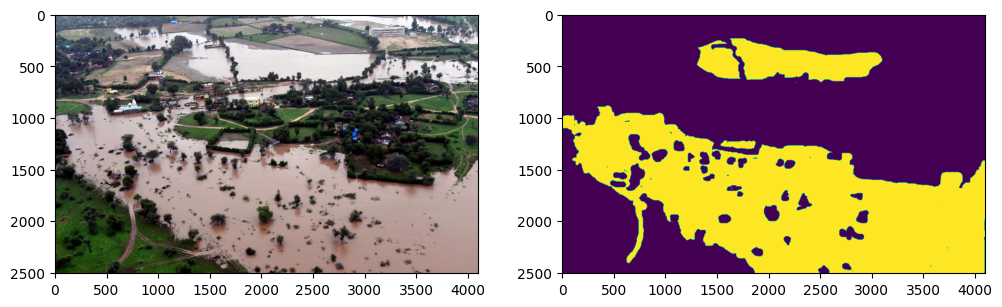

['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Image/27.jpg'] ['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Mask/27.png']


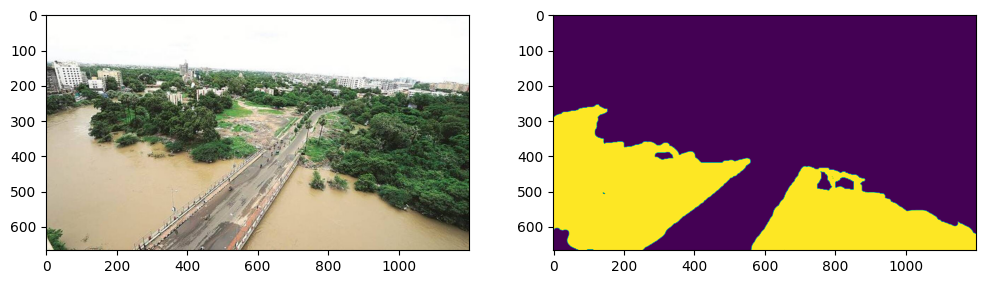

['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Image/19.jpg'] ['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Mask/19.png']


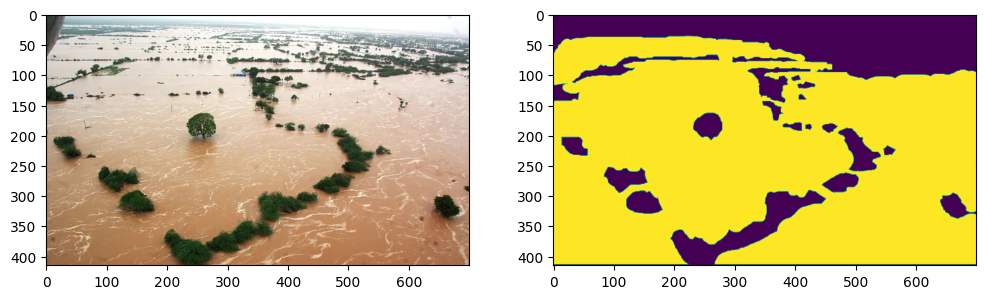

['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Image/1020.jpg'] ['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Mask/1020.png']


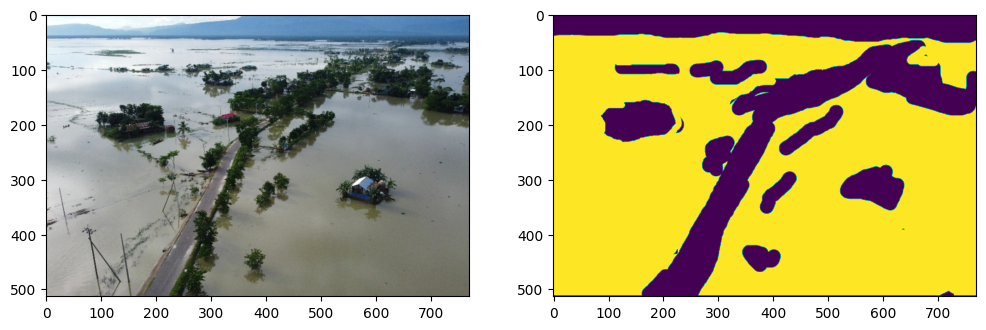

['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Image/2029.jpg'] ['/home/jvdboss/workspace/ML_DL/flood_area_segmentation/archive/Mask/2029.png']


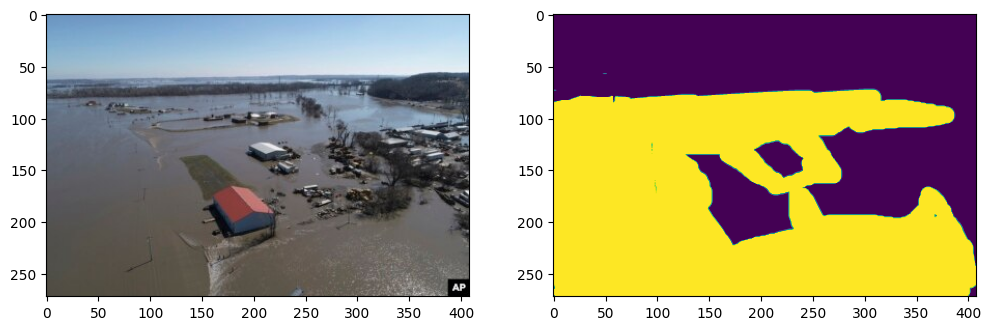

In [6]:
for i in range(5):
    sample = df.sample(n = 1)
    print(sample['Image'].values, sample['Mask'].values)

    img = plt.imread(sample.iloc[0,0], 0)
    mask = plt.imread(sample.iloc[0, 1], 0)

    plt.figure(figsize = (12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    img.shape, mask.shape

    plt.show()

In [7]:
# Setting the image input size
IMG_SIZE = (224, 224)

# The below function is used to change the dimensions of the masked images
def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.5, 1)
    return t_mask

# The below function is used to map the images with masked images
def map_function(img, mask, training):
    img, mask = plt.imread(img.decode())[:, :, :3], plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    
    img = img/255.0
    if training == True:
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
    
    return img.astype(np.float64), mask.astype(np.float64)

In [8]:
# We will set the batch size to 8, It's a hyperparameter
BATCH_SIZE = 8

# Creating a function to transform the data
def create_dataset(data, training = True):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(100)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask, training], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [9]:
# Splitting the data into train and test data
df_train, df_test = train_test_split(df, test_size = 0.3)

print(df_train.shape, df_test.shape)
train_dataset = create_dataset(df_train, training = True)
test_dataset = create_dataset(df_test, training = False)


(203, 2) (87, 2)


2023-01-05 15:37:47.739712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 15:37:47.874972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 15:37:47.875182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 15:37:47.877075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [11]:
# Creating the model
model = sm.Unet('efficientnetb2', 
                input_shape = (224,224,3), 
                classes = 1, 
                activation='sigmoid', 
                encoder_weights='imagenet')

In [12]:
# To check the model summary
# model.summary()

In [13]:
# Compiling the model
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-3),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

---
### Model training

In [14]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 10)

Epoch 1/10


2023-01-05 15:37:58.145840: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'binary_crossentropy/cond/output/_11'
2023-01-05 15:38:02.752324: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-01-05 15:38:05.967675: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, b

26/26 [==============================] - 36s 663ms/step - loss: 0.3876 - iou_score: 0.5309 - val_loss: 1.7424 - val_iou_score: 0.5627
Epoch 2/10
26/26 [==============================] - 11s 367ms/step - loss: 0.3120 - iou_score: 0.6203 - val_loss: 4.3324 - val_iou_score: 0.4322
Epoch 3/10
26/26 [==============================] - 10s 378ms/step - loss: 0.2894 - iou_score: 0.6350 - val_loss: 3.8354 - val_iou_score: 0.4011
Epoch 4/10
26/26 [==============================] - 9s 343ms/step - loss: 0.2807 - iou_score: 0.6546 - val_loss: 5.4759 - val_iou_score: 0.1019
Epoch 5/10
26/26 [==============================] - 9s 331ms/step - loss: 0.2751 - iou_score: 0.6510 - val_loss: 2.0223 - val_iou_score: 0.4016
Epoch 6/10
26/26 [==============================] - 10s 382ms/step - loss: 0.2559 - iou_score: 0.6797 - val_loss: 0.3964 - val_iou_score: 0.6163
Epoch 7/10
26/26 [==============================] - 10s 399ms/step - loss: 0.2421 - iou_score: 0.6907 - val_loss: 0.3779 - val_iou_score: 0.540

/tmp/ipykernel_33119/3689311381.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


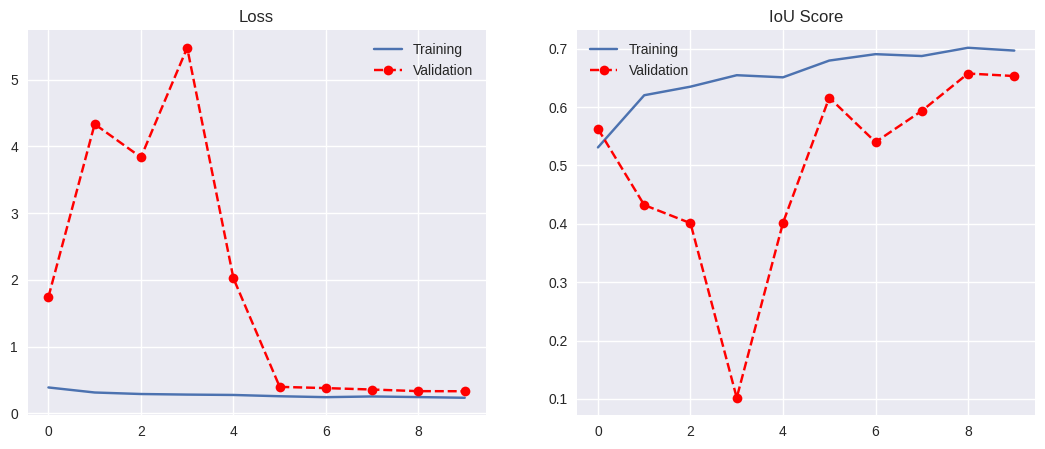

In [15]:
# Plotting the graph for Training loss, Validation loss and Training IOU and Validation IOU
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()


In [16]:
# Using model.evaluate function to evaluate on the test data
model.evaluate(test_dataset)

11/11 [==============================] - 1s 129ms/step - loss: 0.3309 - iou_score: 0.6566


[0.3309050500392914, 0.6566424369812012]

---
### Prediction

In [17]:
color = np.array([161, 205, 255])/255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

(-0.5, 223.5, 223.5, -0.5)

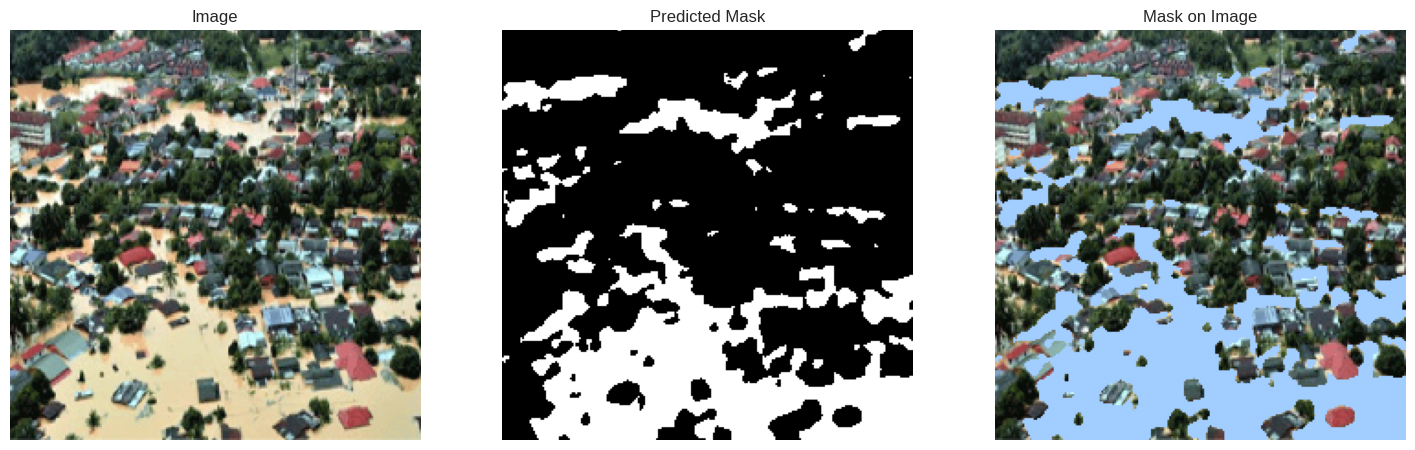

In [42]:
url ='https://raw.githubusercontent.com/jaydeepIneuron007/Dataset/main/0.jpg'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im).convert('RGB'))[:, :,:3]

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))